In this notebook I test the simplest case of the adiabatic theorem I can think of. Take two "Hamiltonians" $A$ and $B$, here 2 $\times$ 2 random Hermitian matrices. Pick a time $T$. Let $| a \rangle $ be an eigenvector of $A$. Evolve it for the time interval $[0, T]$ according to the Hamiltonian
\begin{equation}
    H(t) = (1 - t/T)A + t/T B \;  \tag{1}
\end{equation}
(notice $H(t)$ depends parametrically on $T$). This means solving
\begin{equation}
    \frac{d}{dt} | \psi (t) \rangle = - i H(t) | \psi (t) \rangle \tag{2}
\end{equation}
with initial condition $| \psi (0) \rangle = | a \rangle $.
Then *if $T$ is long enough* the final state vector $| \psi(T) \rangle $ is approximately an eigenstate of $B$. More in general, $| \psi(t) \rangle $ is approximately an eigenstate of $H(t)$ for all $t \in [0,1]$.

We check this as follows:
- Fix $T$ (parameter of the code)
- Get the unitary $U_A$ s.t. $U_A A U_A^{\dagger}$ is diagonal, i.e. whose columns are eigenvectors of $A$. 
- Evolve the two eigenvectors simultaneously by solving
\begin{equation}
    \frac{d}{dt} U(t) = - i H(t) \cdot U(t) \tag{3}
\end{equation}
with initial condition $U(0) = U_A$, on the time interval $[0,T]$.
- Do some unitarity check on numerical solution $U(t)$
- Check whether $U(t) H(t) U(t)^{\dagger}$ is diagonal for all/various times $t$, i.p. for $t=T$ and $H(T) = B$

In [96]:
import numpy as np
from scipy.integrate import solve_ivp

In [97]:
def sample_hermitian_matrix():
    real_part = np.random.randn(2, 2)
    imag_part = np.random.randn(2, 2)
    matrix = real_part + 1j * imag_part
    hermitian_matrix = (matrix + matrix.conj().T) / 2
    return hermitian_matrix

# Sampled A and B:
A = sample_hermitian_matrix()
B = sample_hermitian_matrix()

#B = A #switch this on for sanity checks (sets a time-independent H(t) = A)

# Define the function H |---> H(t) matrix
def H(t):
    return (1 - t/T) * A + (t/T) * B

#eigenvectors of A
U_A = np.linalg.eigh(A)[1]
#print(U_A)

#(np.conj(U_A.T) @ A @ U_A).round(5) #CHECK OK

In [98]:
# Define your list of T values here
T_list = [10**(-1 + j * .25) for j in range(18)]
U_T_list = [] #will contain the result of evolving U_A with eq. (3) with H given by Eq. (2)
#T_list[-1]

In [99]:
#convention: _flat for flattened matrices with separated real and imag parts, i.e. el. of R^8; no specification for matrices

def complex_to_real_imag(x):
    return np.concatenate((np.real(x), np.imag(x)))
def real_imag_to_complex(real_imag):
    n_half = int(len(real_imag)/2)
    return real_imag[:n_half] + 1.j * real_imag[n_half:]
def matrix_to_flat(matrix):
    return complex_to_real_imag(matrix.flatten())
def flat_to_matrix(flattened):
    return (real_imag_to_complex(flattened)).reshape((2,2))
    
def matrix_differential_equation(t, U_flat, H_func): #U_flat is a flattened matrix in R^8; H_func is a function t |--> matrix H_mat_func(t)
    U = flat_to_matrix(U_flat)
    dUdt = -1.j * H_func(t) @ U
    return matrix_to_flat(dUdt)

# Initial condition
U_A_flat = matrix_to_flat(U_A)

for T in T_list:
    # Time interval
    t_span = (0, T)
    num_values = 100
    t_list = np.linspace(0, T, num_values + 1)

    # Solve the differential equation
    solution = solve_ivp(matrix_differential_equation, t_span, U_A_flat, args=(H,), t_eval=t_list)

    #solution.y[0] is a list of values Re(U_00(t)) for t in t_list, solution.y[1] is a list of values Re(U_01(t)), etc

    U_T_flat = np.array([solution.y[i][num_values] for i in range(8)])
    U_T = real_imag_to_complex(U_T_flat).reshape((2,2))
    U_T_list.append(U_T)

In [100]:
# check unitarity of U_T's...
(U_T_list[-1] @ np.conj(U_T_list[-1].T)).round(2)

array([[ 1.02-0.j  , -0.01-0.12j],
       [-0.01+0.12j,  1.16-0.j  ]])

For all valued of $T$ we considered, we now check how much $U(T) B U(T)^{\dagger}$ deviates from being diagonal, i.e. how much the evolution after time $T$ of the two eigenstates of $A$ deviates from the two eigenstates of $B$. Here $U(T)$ is the matrix you get by solving eq. (3) with the Hamiltonian of Eq. (1) for a time $T$ and with initial condition $ U(0) = U_A$. We do this by plotting
\begin{equation}
    D(T) = | \text{off diagonal element of } U(T) B U(T)^{\dagger}| \; .
\end{equation}


In [101]:
# now we check "how well" the matrices U_T diagonalize B
approx_B_diag_list = []
off_diag_elements_of_approx_B_list = []
#print(np.linalg.eigh(B)[0].round(3)) # CHECK OK
for j in range (len(T_list)):
    T = T_list[j]
    U_T = U_T_list[j]
    approx_B_diag = np.conj(U_T.T) @ B @ U_T
    approx_B_diag_list.append(approx_B_diag)
#    print(approx_B_diag.round(3), "\n")
    off_diag_elements_of_approx_B_list.append(np.absolute(approx_B_diag[0][1]))


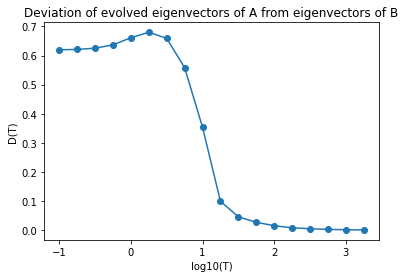

In [102]:
import matplotlib.pyplot as plt

plt.plot(np.log10(T_list), off_diag_elements_of_approx_B_list, marker='o')
plt.title('Deviation of evolved eigenvectors of A from eigenvectors of B')
plt.xlabel('log10(T)')
plt.ylabel('D(T)')
plt.show()
